In [ ]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwpy==3.0.8'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from gwosc.datasets import event_gps
gps = event_gps('GW190814')
print(gps)

1249852257.0


Mounted at /content/drive/
/content/drive
1249852251 1249852259


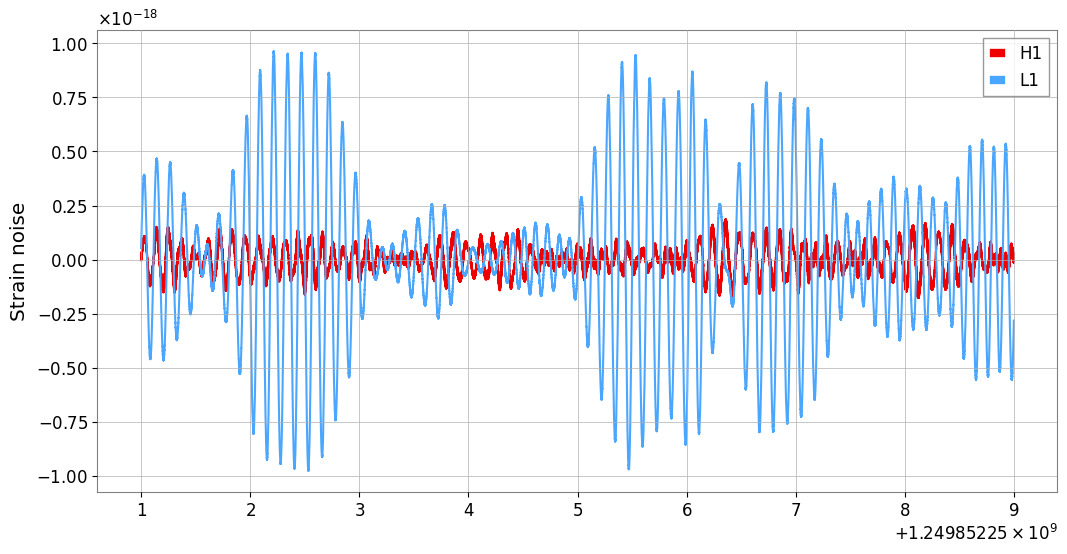

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/
fileNameL = "/content/drive/My Drive/GW190814/L-L1_GWOSC_4KHZ_R1-1249852241-32.hdf5"
fileNameH = "/content/drive/My Drive/GW190814/H-H1_GWOSC_4KHZ_R1-1249852241-32.hdf5"

# Extract the Strain data and plot

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

data = {}
segment = (int(gps) -6, int(gps) + 2)
print(segment[0],segment[1])
plot = Plot(figsize=(12,6))
ax = plot.gca()
#ax.set_epoch(gps)

for ifo in ['H1', 'L1']:
    if ifo == 'H1':
       data[ifo] = TimeSeries.read(fileNameH, start=segment[0], end=segment[1], format="hdf5.gwosc")
       clabel = 'gwpy:ligo-Hanford'
    else:
       data[ifo] = TimeSeries.read(fileNameL, start=segment[0], end=segment[1], format='hdf5.gwosc')
       clabel = 'gwpy:ligo-Livingston'
    ax.plot(data[ifo],label=ifo, color=clabel)
    ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

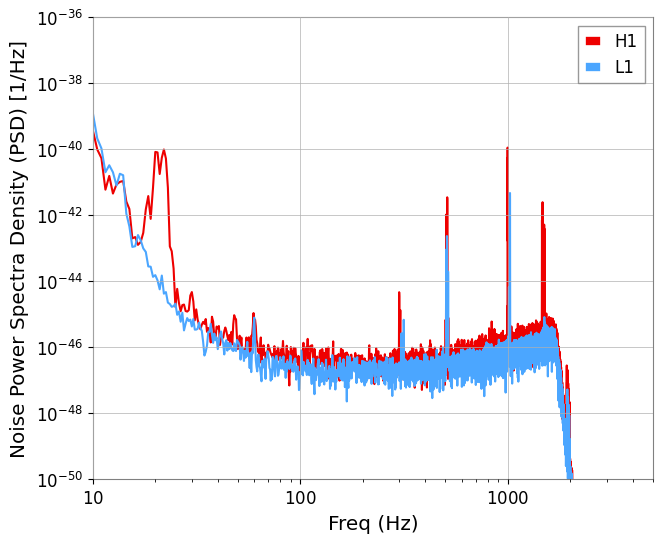

In [ ]:
# Power Spectral density of the original data

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from gwpy.plot import Plot

t0 = int(gps)-6  # time epoch of GW190814
length = 8 #-- Number of seconds

plot = Plot(figsize=[8, 6])
ax = plot.gca()

for ifo in data:
    str_fs=str(data[ifo].sample_rate).split(' ')   # 4096 Hz
    fs=int(float(str_fs[0])) #-- Sampling frequency
    #print fs

    str_dt=str(data[ifo].dt).split(' ')
    dt=float(str_dt[0])
    #print dt
    #print data[ifo][0]

    strain_seg = data[ifo][0:(length*fs)]
    time_seg = [t0+i*dt for i in range(len(data[ifo]))]

    asd = strain_seg.psd(fftlength=2)
    if ifo == 'H1':
       clabel = 'gwpy:ligo-Hanford'
    else:
       clabel = 'gwpy:ligo-Livingston'
    ax.plot(asd,label=ifo, color=clabel)
#    ax.legend()
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.set_ylim(1e-50, 1e-36)
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plot.show()

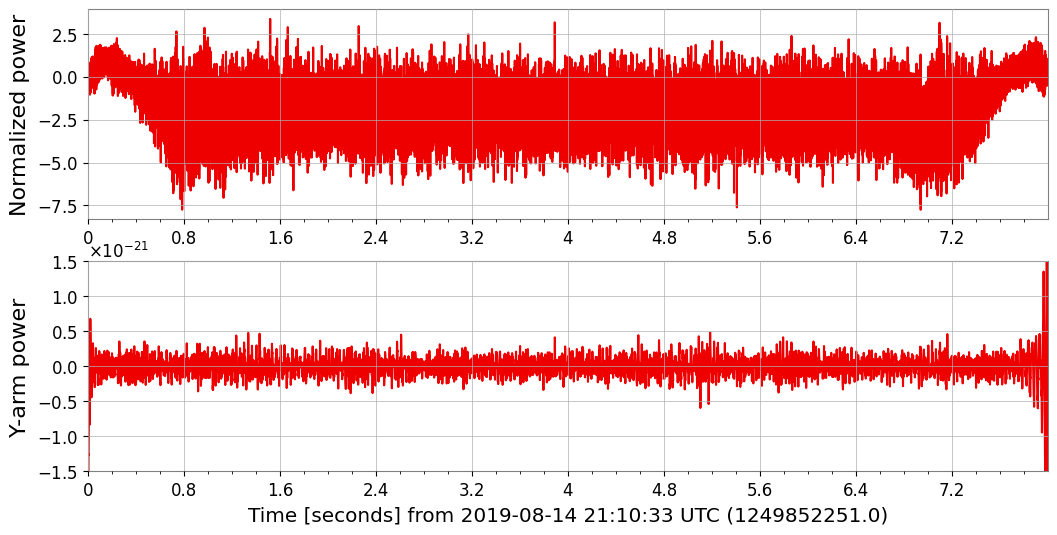

In [ ]:
# Artificial effect imposed on the original data

from gwpy.signal import filter_design


white = {}
data_bp = {}
data_clean = {}


for ifo in data:
    white[ifo] = data[ifo].whiten(4,2)  #whitening data with estimation of 8s in FFT and overlaping of 0 s
    data_bp[ifo] = data[ifo].bandpass(30, 250, filtfilt=True) #band pass by 30 and 250 Hz
#    notches = [filter_design.notch(f, data[ifo].sample_rate) for f in (45, 90, 135)]
#    powernotch = filter_design.concatenate_zpks(*notches)  #filter out the noises in n*60 Hz
#    data_clean[ifo] = data_bp[ifo].filter(powernotch, filtfilt=True)
    if ifo == 'H1':
       clabel = 'gwpy:ligo-Hanford'
       plot1 = Plot(white[ifo], data_bp[ifo], color=clabel, separate=True, sharex=True)
       ax1, ax2 = plot1.axes
       ax1.set_ylabel('Normalized power', fontsize=16)
       ax2.set_ylabel('Y-arm power', fontsize=16)
       ax2.set_ylim(-1.5e-21, 1.5e-21)
#      ax3.set_ylabel('filter notches', fontsize=16)
#      ax3.set_ylim(-1.5e-21, 1.5e-21)

Text(0, 0.5, 'Y-arm power')

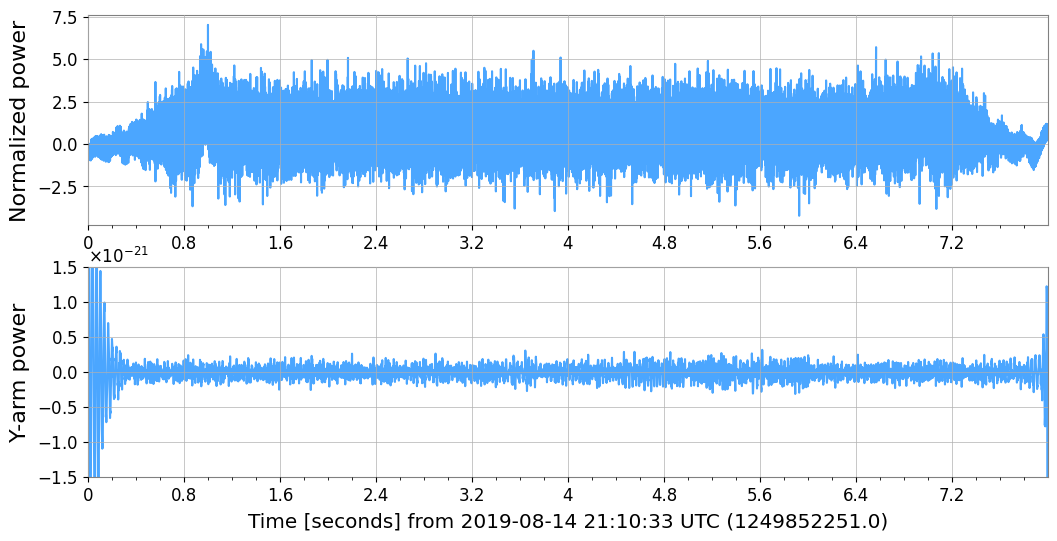

In [ ]:
clabel = 'gwpy:ligo-Livingston'
plot = Plot(white['L1'], data_bp['L1'], color=clabel, separate=True, sharex=True)
ax1, ax2 = plot.axes
ax1.set_ylabel('Normalized power', fontsize=16)
ax2.set_ylim(-1.5e-21, 1.5e-21)
ax2.set_ylabel('Y-arm power', fontsize=16)

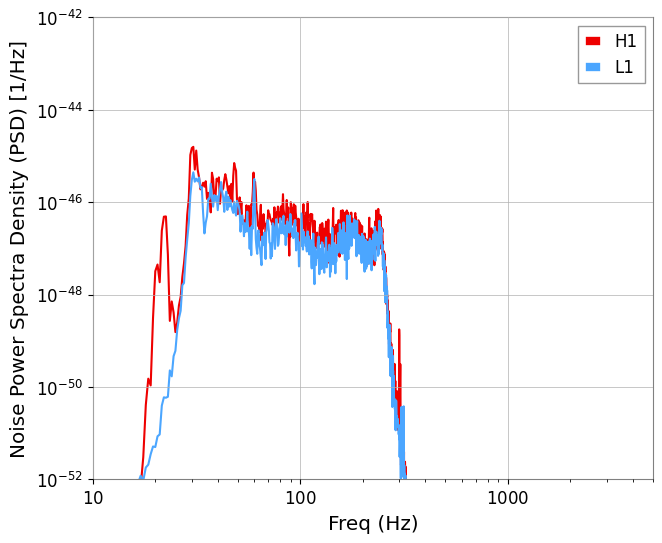

In [ ]:
# Power Spectral density of the clean data via bandpassing and notching

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from gwpy.plot import Plot

t0 = int(gps)-6  # time epoch of GW190814
length = 8 #-- Number of seconds

plot = Plot(figsize=[8, 6])
ax = plot.gca()

for ifo in data:
    str_fs=str(data_bp[ifo].sample_rate).split(' ')   # 4096 Hz
    fs=int(float(str_fs[0])) #-- Sampling frequency
    #print fs

    str_dt=str(data_bp[ifo].dt).split(' ')
    dt=float(str_dt[0])
    #print dt
    #print data[ifo][0]

    strain_seg = data_bp[ifo][0:(length*fs)]
    time_seg = [t0+i*dt for i in range(len(data_bp[ifo]))]

    asd = strain_seg.psd(fftlength=2)
    if ifo == 'H1':
       clabel = 'gwpy:ligo-Hanford'
    else:
       clabel = 'gwpy:ligo-Livingston'
    ax.plot(asd,label=ifo, color=clabel)
#    ax.legend()
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.set_ylim(1e-52, 1e-42)
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plot.show()

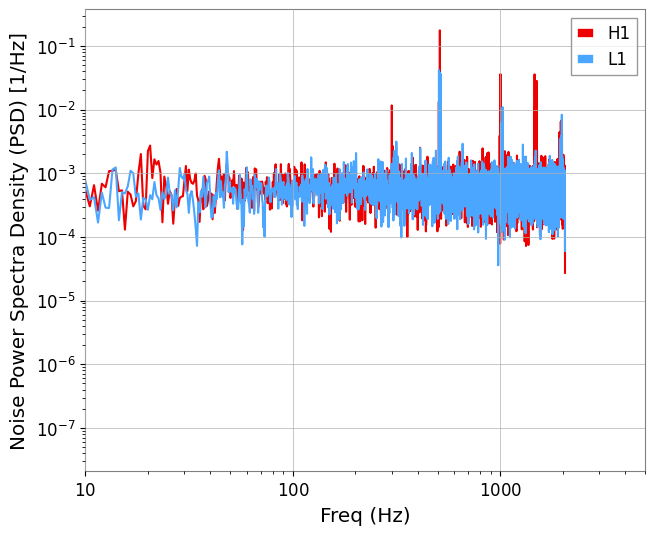

In [ ]:
# Power Spectral density of the whitened data

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from gwpy.plot import Plot

t0 = int(gps)-6  # time epoch of GW190814
length = 8 #-- Number of seconds

plot = Plot(figsize=[8, 6])
ax = plot.gca()

for ifo in data:
    str_fs=str(white[ifo].sample_rate).split(' ')   # 4096 Hz
    fs=int(float(str_fs[0])) #-- Sampling frequency
    #print fs

    str_dt=str(white[ifo].dt).split(' ')
    dt=float(str_dt[0])
    #print dt
    #print data[ifo][0]

    strain_seg = white[ifo][0:(length*fs)]
    time_seg = [t0+i*dt for i in range(len(data_bp[ifo]))]

    asd = strain_seg.psd(fftlength=2)
    if ifo == 'H1':
       clabel = 'gwpy:ligo-Hanford'
    else:
       clabel = 'gwpy:ligo-Livingston'
    ax.plot(asd,label=ifo, color=clabel)
#    ax.legend()
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
#ax.set_ylim(1e-52, 1e-42)
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plot.show()

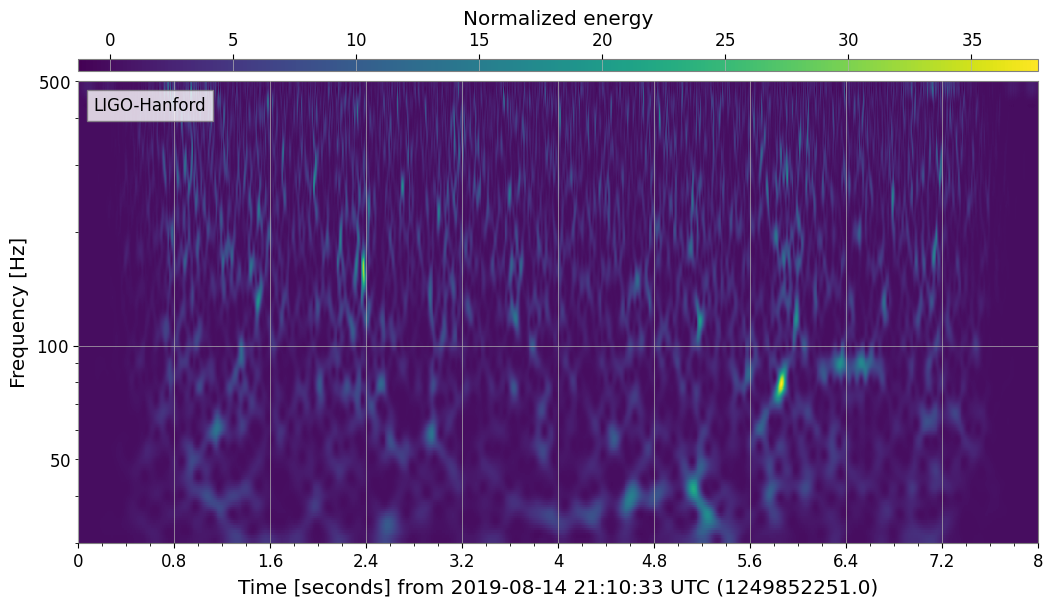

In [ ]:
# Q transform of the whitened data

white_q = {}
for ifo in data:
    white_q[ifo]=white[ifo].q_transform(frange=(30, 500), qrange=(15,80), whiten=False)


plot=white_q['H1'].plot()
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(30, 500)
ax.set_ylabel('Frequency [Hz]')
ax.plot(gps, 0, label='LIGO-Hanford', visible=False)
ax.legend(loc='upper left', handlelength=0, handletextpad=0)
#ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy',location='top')
plot.show()

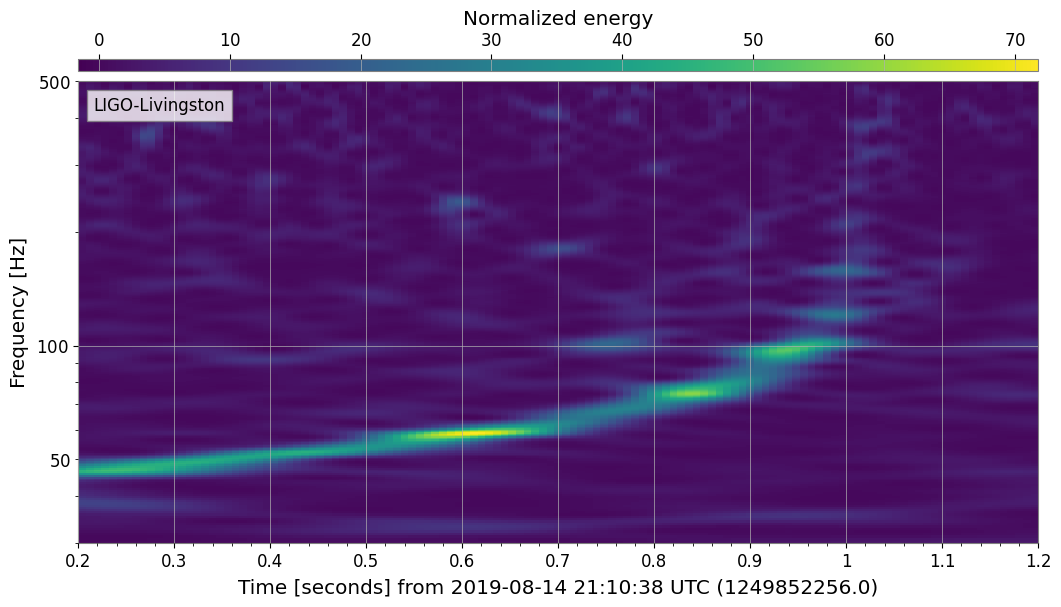

In [ ]:
# Q transform of the whitened data

white_q = {}
for ifo in data:
    white_q[ifo]=white[ifo].q_transform(frange=(30, 500), qrange=(15,80), whiten=False)


plot=white_q['L1'].plot()
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(30, 500)
ax.set_xlim(gps-0.8, gps+0.2)
ax.set_ylabel('Frequency [Hz]')
ax.plot(gps, 0, label='LIGO-Livingston', visible=False)
ax.legend(loc='upper left', handlelength=0, handletextpad=0)
#ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy',location='top')
plot.show()

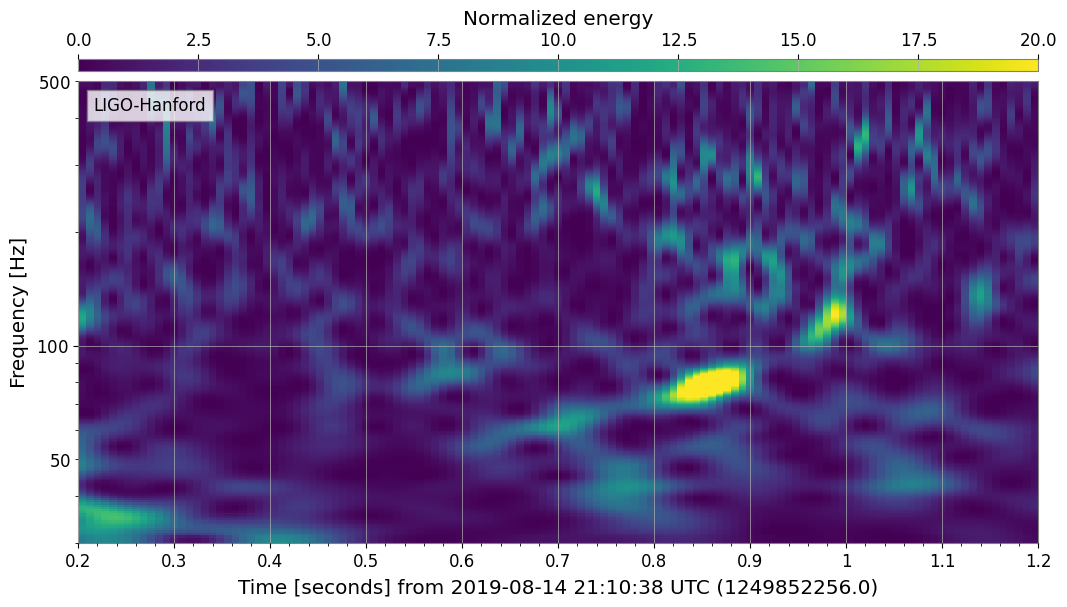

In [ ]:
# Q transform of the original data with the whitening support in the package

data_q = {}
for ifo in data:
    data_q[ifo]=data_bp[ifo].q_transform(frange=(30, 500), qrange=(12,80))  #default whiten = yes

plot=data_q['H1'].plot()
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(30, 500)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlim(gps-0.8, gps+0.2)
ax.plot(gps, 0, label='LIGO-Hanford', visible=False)
ax.legend(loc='upper left', handlelength=0, handletextpad=0)
#ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy',location='top', vmin=0, vmax=20)
plot.show()

In [ ]:
import h5py

time_seg = [t0+i*dt for i in range(len(data[ifo]))]

with h5py.File('/content/drive/My Drive/GW190814/GW190814.hdf5','w') as ff:
#ff=h5py.File("GW190814.hdf5","w")
  f1=ff.create_group("info")
  f1["TIME"] = time_seg
  f1["gps"] = gps
  f1["rate"] = data['H1'].sample_rate
  f1["H1_strain"] = white['H1'] #whitened data, data['H1'] and data['L1'] are the original time series
  f1["L1_strain"] = white['L1']

ff.close()